In [5]:
import cv2
import os
import numpy as np
import math

In [ ]:
def extract_frames_from_video(video_path):
    """
    동영상의 경로를 입력받아, 동영상 파일이 위치한 디렉토리에
    동영상 이름의 폴더를 생성하고 각 프레임을 이미지 파일로 추출하여 저장합니다.
    """
    # 0. jpeg 압축률 설정
    compression_quality = 90 
    
    # 1. 동영상 파일 열기
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"오류: 동영상 파일 '{video_path}'을(를) 열 수 없습니다.")
        return

    # 2. 출력 폴더 이름 및 경로 설정 수정
    # 동영상 파일의 전체 경로에서 디렉토리 경로 추출 (예: D:\study)
    video_dir = os.path.dirname(video_path)
    # 파일 이름에서 확장자(.mp4, .avi 등) 제거 (예: Download)
    base_name = os.path.splitext(os.path.basename(video_path))[0]
    
    # 출력 폴더 경로 설정: 동영상 디렉토리 + 동영상 이름 (예: D:\study\Download)
    output_dir = os.path.join(video_dir, base_name)

    # 3. 출력 폴더 생성
    try:
        # 폴더가 존재하지 않으면 생성
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"폴더 생성 완료: {output_dir}")
        else:
            print(f"경고: 폴더 '{output_dir}'이(가) 이미 존재합니다. 기존 파일에 덮어쓰거나 추가됩니다.")
    except OSError as e:
        print(f"오류: 폴더 생성 실패 - {e}")
        cap.release()
        return

    # 4. 프레임 추출 및 저장
    frame_count = 0
    print("프레임 추출을 시작합니다...")

    # 프레임 총 개수 가져오기 (진행률 표시를 위해)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # 파일 이름 형식: frame_00000.jpg (5자리 숫자로 패딩)
        frame_filename = os.path.join(output_dir, f"frame_{frame_count:05d}.jpg")

        # 프레임을 JPG 파일로 저장
        cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_JPEG_QUALITY, compression_quality])

        # 진행률 표시
        if frame_count % 100 == 0:
            print(f"진행 중: {frame_count}/{total_frames} 프레임 추출...", end='\r')

        frame_count += 1

    # 5. 종료 및 정리
    cap.release() # 비디오 캡처 객체 해제
    print(f"\n--- 추출 완료 ---")
    print(f"총 {frame_count}개의 프레임이 '{output_dir}'에 저장되었습니다.")


# --- 사용 예시 ---
# 사용 예시 경로를 실제 존재하는 경로로 변경해야 합니다.

# video_file_path = r"D:\study\for_MAICON\0001.mkv" 
# extract_frames_from_video(video_file_path) 


폴더 생성 완료: D:\study\for_MAICON\0001
프레임 추출을 시작합니다...
진행 중: 100/120 프레임 추출...
--- 추출 완료 ---
총 120개의 프레임이 'D:\study\for_MAICON\0001'에 저장되었습니다.


In [84]:
def process_image_correction_no_viz(file_path, output_path):
    """
    이미지를 로드하고, 기울기를 감지하여 보정 각도로 회전한 후 저장합니다.
    
    회전된 이미지는 원본 크기를 유지하며, 잘리는 부분은 흰색(255, 255, 255)으로 채워집니다.
    시각화(Matplotlib)는 포함되지 않습니다.

    Args:
        file_path (str): 로드할 원본 이미지 파일 경로.
        output_path (str): 회전된 이미지를 저장할 파일 경로.
    """
    
    # 1. 이미지 로드
    img = cv2.imread(file_path)

    if img is None:
        print(f"오류: 이미지를 찾을 수 없습니다. 파일 경로를 확인하세요: {file_path}")
        return

    # 2. 흑백 변환 및 엣지 검출 (기울기 계산 로직)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # [수정] maxGap -> maxLineGap
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

    angles = []
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle_rad = math.atan2(y2 - y1, x2 - x1)
            angle_deg = math.degrees(angle_rad)
            
            # 각도를 -90 ~ 90 범위로 정규화
            if angle_deg < -45:
                angle_deg += 180
            elif angle_deg > 45:
                angle_deg -= 180
            
            # 수평/수직에 가까운 선만 고려 (15도 이내)
            if abs(angle_deg) < 15:
                angles.append(angle_deg)

    # 3. 평균 각도 계산 및 보정 각도 설정
    mean_angle = 0.0
    if angles:
        mean_angle = np.mean(angles)
        print(f"검출된 평균 회전 각도 (이미지의 기울기): {mean_angle:.2f} 도.")
    else:
        print("경고: 적절한 선을 검출하지 못했습니다. 회전 보정을 건너뜁니다.")

    # 보정 각도 (기울어진 각도만큼 회전)
    rotation_angle = mean_angle 

    print(f"이미지 보정을 위해 적용할 회전 각도: {rotation_angle:.2f} 도.")
    
    # 4. 이미지 회전 함수 (원본 크기 유지 및 흰색 채움)
    def rotate_image_fixed_size(image, angle):
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        
        # 회전 행렬 생성 (스케일 1.0 유지)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # 실제 회전 실행. 출력 크기는 원본 (w, h)를 그대로 사용.
        # borderValue=(255, 255, 255)는 흰색(White)으로 채우라는 의미입니다.
        rotated = cv2.warpAffine(image, M, (w, h), borderValue=(255, 255, 255)) 
        return rotated

    # 5. 회전 적용
    rotated_img = rotate_image_fixed_size(img, rotation_angle)
    
    # 6. 저장
    cv2.imwrite(output_path, rotated_img)
    
    print(f"\n[저장 완료] 보정된 이미지: {output_path}")

# --- 함수 사용 예시 ---
image_a = r'D:\study\for_MAICON\untitled_evee_rotated_10_2dot5.png'
image_b = r'.\rotated_image.png'
process_image_correction_no_viz(file_path=image_a,output_path=image_b)


검출된 평균 회전 각도 (이미지의 기울기): 9.85 도.
이미지 보정을 위해 적용할 회전 각도: 9.85 도.

[저장 완료] 보정된 이미지: .\rotated_image.png


In [85]:
# ------ detect_aruco_in_image 설정 (전역 변수) ------
# 1. 사용할 ArUco 딕셔너리
ARUCO_DICT_TYPE = cv2.aruco.DICT_4X4_50
# 2. 이미지 확대 비율 (작은 마커 검출에 중요)
SCALE_FACTOR = 2.0 
# ---------------------------------------------------


def detect_aruco_in_image(file_path, output_path):
    """
    지정된 이미지 파일에서 ArUco 마커를 검출하고 결과를 표시한 후 저장합니다.
    검출된 마커의 ID와 코너 좌표를 리스트 형태로 반환합니다.
    
    Args:
        file_path (str): 로드할 원본 이미지 파일 경로.
        output_path (str): 마커가 표시된 결과 이미지를 저장할 경로.
        
    Returns:
        list: 검출된 마커 정보 리스트. 각 요소는 다음과 같은 딕셔너리입니다:
              [{'id': int, 'corners': numpy.ndarray}, ...]
              코너 좌표는 확대된 이미지(scaled_image) 기준입니다.
    """
    
    # 1. 이미지 파일 로드
    image = cv2.imread(file_path)

    if image is None:
        print(f"오류: 이미지 파일 '{file_path}'을(를) 로드할 수 없습니다. 경로를 확인하세요.")
        return [] # 오류 시 빈 리스트 반환

    # 이미지 확대 (Upscaling)
    scaled_image = cv2.resize(
        image, 
        None, 
        fx=SCALE_FACTOR, 
        fy=SCALE_FACTOR, 
        interpolation=cv2.INTER_CUBIC
    )
    
    # 2. ArUco 검출기 설정
    aruco_dict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT_TYPE)
    parameters = cv2.aruco.DetectorParameters()
    parameters.minMarkerPerimeterRate = 0.01
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    # 3. 마커 검출 (확대된 이미지 사용)
    corners, ids, rejected = detector.detectMarkers(scaled_image)
    
    # 검출된 마커 정보를 저장할 리스트
    detected_markers = [] 

    # 4. 검출 결과 처리 및 표시
    if ids is not None:
        print(f"총 {len(ids)}개의 ArUco 마커가 검출되었습니다.")
        
        # 검출된 마커 주변에 경계선과 ID 표시
        for i in range(len(ids)):
            c = corners[i][0] # 코너 좌표 (4x2 numpy 배열)
            marker_id = ids[i][0]
            
            # --- 반환값에 추가 ---
            detected_markers.append({
                'id': marker_id,
                # 코너 좌표는 numpy 배열 형태 그대로 저장
                'corners': c 
            })
            # --------------------
            
            # 마커 경계선 그리기 (초록색)
            cv2.polylines(
                scaled_image,
                [np.int32(c)],
                isClosed=True,
                color=(0, 255, 0),
                thickness=3
            )
            
            # ID 표시 (빨간색)
            top_left = tuple(np.int32(c[0]))
            cv2.putText(
                scaled_image,
                str(marker_id),
                top_left,
                cv2.FONT_HERSHEY_SIMPLEX,
                SCALE_FACTOR * 0.3,
                (0, 0, 255),
                2,
                cv2.LINE_AA
            )
            print(f" - ID: {marker_id}, Top-Left Corner (Scaled): {top_left}")

    else:
        print("이미지에서 ArUco 마커를 찾을 수 없습니다.")

    # 5. 결과 이미지 저장
    try:
        cv2.imwrite(output_path, scaled_image)
        print(f"\n[저장 완료] 마커가 표시된 확대 이미지: '{os.path.abspath(output_path)}'에 성공적으로 저장되었습니다.")
    except Exception as e:
        print(f"\n[저장 오류] 이미지 저장 중 문제가 발생했습니다: {e}")
        
    # 6. 검출된 마커 정보 반환
    return detected_markers

# --- 함수 사용 예시 ---
image_c=r'.\aruco_image.png'

# # 함수를 호출하고 반환값을 변수에 저장
aruco_marker_results = detect_aruco_in_image(file_path=image_b, output_path=image_c)

 # 반환된 결과를 출력
if aruco_marker_results:
    print("\n--- 검출된 마커 정보 (반환값) ---")
    for marker in aruco_marker_results:
        print(f"마커 ID: {marker['id']}")
        # 코너 좌표는 4개의 (x, y) 좌표로 구성됩니다.
        print(f"코너 좌표 (Scaled): \n{marker['corners']}\n")
else:
    print("\n검출된 마커 정보가 없습니다.")

총 8개의 ArUco 마커가 검출되었습니다.
 - ID: 5, Top-Left Corner (Scaled): (np.int32(4704), np.int32(2880))
 - ID: 3, Top-Left Corner (Scaled): (np.int32(4557), np.int32(1681))
 - ID: 4, Top-Left Corner (Scaled): (np.int32(5067), np.int32(1687))
 - ID: 2, Top-Left Corner (Scaled): (np.int32(3504), np.int32(1674))
 - ID: 10, Top-Left Corner (Scaled): (np.int32(1949), np.int32(4237))
 - ID: 6, Top-Left Corner (Scaled): (np.int32(3508), np.int32(2877))
 - ID: 1, Top-Left Corner (Scaled): (np.int32(2995), np.int32(1675))
 - ID: 0, Top-Left Corner (Scaled): (np.int32(2372), np.int32(1675))

[저장 완료] 마커가 표시된 확대 이미지: 'c:\Users\seaga\OneDrive\Documents\GitHub\2025Maicon\aruco_image.png'에 성공적으로 저장되었습니다.

--- 검출된 마커 정보 (반환값) ---
마커 ID: 5
코너 좌표 (Scaled): 
[[4704. 2880.]
 [4798. 2882.]
 [4796. 2975.]
 [4703. 2974.]]

마커 ID: 3
코너 좌표 (Scaled): 
[[4557. 1681.]
 [4650. 1682.]
 [4649. 1776.]
 [4556. 1775.]]

마커 ID: 4
코너 좌표 (Scaled): 
[[5067. 1687.]
 [5161. 1688.]
 [5160. 1781.]
 [5066. 1779.]]

마커 ID: 2
코너 좌표 (Scaled

In [86]:
def get_marker_center_point(results, marker_id):
    """
    ArUco 마커 검출 결과에서 특정 ID를 가진 마커의 중심 좌표를 계산합니다.

    Args:
        results (list): detect_aruco_in_image 함수가 반환한 마커 정보 리스트.
        marker_id (int): 중심을 찾고자 하는 마커의 ID.

    Returns:
        tuple or None: (Center_X, Center_Y) Array 또는 마커를 찾지 못한 경우 None.
    """
    for marker in results:
        if marker['id'] == marker_id:
            # 'corners'는 (4, 2) 형태의 NumPy 배열입니다.
            corners = marker['corners']
            
            # NumPy의 mean 함수를 사용하여 4개 코너 좌표의 평균을 계산합니다.
            # axis=0은 각 열(X 좌표, Y 좌표)의 평균을 계산합니다.
            # 결과는 [Center_X, Center_Y] 형태의 NumPy 배열입니다.
            center = np.mean(corners, axis=0)
            
            
            return center
            
    return None # 해당 ID의 마커를 찾지 못한 경우

center_point=get_marker_center_point(aruco_marker_results,6)

print(center_point)

half_center_point = center_point/2

print(half_center_point)

[3554.  2924.5]
[1777.   1462.25]


In [87]:
# =======================================================
# 1. 전역 변수 설정: 이미지 내의 목표 기준점 (배열 형식)
#    [Target_X, Target_Y]
# =======================================================
# 예시: 이미지의 (400, 300) 위치로 기준점을 옮기고 싶다.
GLOBAL_TARGET_POINT = np.array([2017, 1462], dtype=np.float32)


def align_image_to_target(input_path: str, output_path: str, current_point: np.ndarray) -> np.ndarray:
    """
    이미지 내의 'current_point'를 'GLOBAL_TARGET_POINT' 위치로 이동시키도록
    이미지 전체를 이동(Translation)시키고 저장하는 함수.

    Args:
        input_path (str): 입력 이미지 파일 경로.
        output_path (str): 이동된 이미지를 저장할 파일 경로.
        current_point (np.ndarray): 현재 이미지 내의 기준점 [Current_X, Current_Y].
    
    Returns:
        np.ndarray: 계산된 이동 벡터 [dx, dy]. 이미지 처리 실패 시 빈 배열 반환.
    """
    
    # --- 1. 이미지 로드 ---
    if not os.path.exists(input_path):
        print(f"오류: 입력 파일 경로를 찾을 수 없습니다: {input_path}")
        # 실패 시 이동량 0인 배열 반환
        return np.array([0.0, 0.0], dtype=np.float32)
        
    try:
        img = cv2.imread(input_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"오류: 이미지를 로드할 수 없습니다. 파일이 유효한 이미지 파일인지 확인하세요: {input_path}")
            return np.array([0.0, 0.0], dtype=np.float32)
    except Exception as e:
        print(f"이미지 로드 중 예외 발생: {e}")
        return np.array([0.0, 0.0], dtype=np.float32)

    rows, cols = img.shape[:2]

    # --- 2. 이동 벡터 계산 (Translation Vector) ---
    # 변환 벡터 (T) = 목표 위치 (G) - 현재 위치 (L)
    translation_vector = GLOBAL_TARGET_POINT - current_point
    
    dx = translation_vector[0]
    dy = translation_vector[1]
    
    print("--- 이미지 정렬 정보 ---")
    print(f"전역 목표 위치 (G): {GLOBAL_TARGET_POINT}")
    print(f"현재 기준점 (L): {current_point}")
    print(f"계산된 이동량 (dx, dy): ({dx:.2f}, {dy:.2f})")

    # --- 3. 이동(Translation) 변환 행렬 M 생성 ---
    # M = [[1, 0, dx],
    #      [0, 1, dy]]
    M = np.float32([[1, 0, dx], 
                    [0, 1, dy]])

    # --- 4. 어파인 변환 적용 (이미지 이동) ---
    # dsize는 (너비, 높이) 순서
    translated_img = cv2.warpAffine(img, M, (cols, rows),borderValue=(255,255,255))

    # --- 5. 이미지 저장 ---
    try:
        cv2.imwrite(output_path, translated_img)
        print(f"성공: 이미지가 저장되었습니다 -> {output_path}")
    except Exception as e:
        print(f"오류: 이미지 저장 실패 -> {output_path}. 예외: {e}")
        # 저장 실패 시에도 계산된 벡터는 반환
        
    # --- 6. 계산된 이동 벡터 반환 ---
    return translation_vector

# =======================================================
# 사용 예시
# =======================================================

image_d = '.\moved_image.png'

# # 2. 함수 실행 및 이동 벡터 받기
move_vector = align_image_to_target(image_b, image_d, half_center_point)

print(f"\n함수에서 반환된 최종 이동 벡터: {move_vector}")


--- 이미지 정렬 정보 ---
전역 목표 위치 (G): [2017. 1462.]
현재 기준점 (L): [1777.   1462.25]
계산된 이동량 (dx, dy): (240.00, -0.25)
성공: 이미지가 저장되었습니다 -> .\moved_image.png

함수에서 반환된 최종 이동 벡터: [240.    -0.25]


In [81]:
'''
# =======================================================
# 전역 설정 (나디르점과 비행 고도)
# =======================================================
ORIGINAL_NADIR_X = 2000.0
ORIGINAL_NADIR_Y = 1500.0
ALTITUDE_H = 2.5


def calculate_rooftop_coords_with_moved_nadir(df: pd.DataFrame, move_vector: np.ndarray = None) -> pd.DataFrame:
    """
    촬영점이 move_vector만큼 이동했다고 가정하고,
    이동된 나디르점 기준으로 relief displacement를 계산하여 최종 옥상 좌표를 구합니다.

    Args:
        df (pd.DataFrame): 건물 데이터 (index, x, y, height 컬럼 포함)
        move_vector (np.ndarray): 촬영점 이동 벡터 [dx, dy]. None이면 이동하지 않음.
    
    Returns:
        pd.DataFrame: 계산된 결과 데이터프레임
    """
    
    # 0. move_vector 처리 및 이동된 나디르점 계산
    if move_vector is None:
        move_vector = np.array([0.0, 0.0], dtype=np.float32)
        print("move_vector가 None이므로 나디르점을 이동하지 않습니다.")
    else:
        print(f"적용할 촬영점 이동 벡터: {move_vector}")
    
    # 촬영점이 이동하면 나디르점도 함께 이동
    moved_nadir_x = ORIGINAL_NADIR_X + move_vector[0]
    moved_nadir_y = ORIGINAL_NADIR_Y + move_vector[1]
    
    print(f"원본 나디르점: ({ORIGINAL_NADIR_X}, {ORIGINAL_NADIR_Y})")
    print(f"이동된 나디르점: ({moved_nadir_x:.2f}, {moved_nadir_y:.2f})")
    
    # 1. 건물의 바닥 좌표는 그대로 유지 (실제 건물 위치는 변하지 않음)
    df['x_ground'] = df['x']  # 바닥 좌표는 원본 그대로
    df['y_ground'] = df['y']
    
    # 2. 높이 변위 계산 (Relief Displacement) - 이동된 나디르점 기준
    
    # 2-1. 이동된 나디르점과의 차이 계산
    df['dx_nadir'] = df['x_ground'] - moved_nadir_x
    df['dy_nadir'] = df['y_ground'] - moved_nadir_y

    # 2-2. 변위 비율 K 계산 (h/H)
    df['K'] = df['height'] / ALTITUDE_H

    # 2-3. 변위량 계산 (Displacement = (P_ground - P_moved_nadir) * K)
    df['disp_x'] = df['dx_nadir'] * df['K']
    df['disp_y'] = df['dy_nadir'] * df['K']

    # 2-4. 옥상 좌표 계산 (P_rooftop = P_ground + Displacement)
    df['rooftop_x'] = df['x_ground'] + df['disp_x']
    df['rooftop_y'] = df['y_ground'] + df['disp_y']
    
    # 결과 출력용 데이터프레임 정리
    output_df = df[['index', 'x', 'y', 'x_ground', 'y_ground', 'height', 'rooftop_x', 'rooftop_y']]
    
    # 추가 정보 컬럼
    output_df['moved_nadir_x'] = moved_nadir_x
    output_df['moved_nadir_y'] = moved_nadir_y
    
    return output_df


# =======================================================
# 실행부 - 통합 예시
# =======================================================

# 1. 건물 데이터 준비
data = {
    'index': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'x': [1763.5, 2035.0, 2548.0, 2798.0, 2611.0, 2011.5, 1208.0, 2010.0, 2641.0],
    'y': [1120.0, 1059.0, 1069.5, 1117.5, 1663.0, 1660.0, 1791.5, 1943.0, 1945.0],
    'height': [0.728, 0.241, 0.198, 1.050, 0.000, 0.000, 0.809, 0.810, 0.792]
}
df = pd.DataFrame(data)

# 2. 예시: 촬영점 이동 벡터
move_vector = np.array([240.0, -0.25], dtype=np.float32)  # 예시 이동 벡터

# 3. 건물 옥상 좌표 계산 (이동된 나디르점 기준)
result_df = calculate_rooftop_coords_with_moved_nadir(df.copy(), move_vector)

print("\n--- 이동된 나디르점 기준 최종 옥상 좌표 계산 결과 ---")
print(result_df[['index', 'x', 'y', 'height', 'rooftop_x', 'rooftop_y']].to_string(index=False))

print(f"\n사용된 촬영점 이동 벡터: {move_vector}")
print(f"원본 나디르점: ({ORIGINAL_NADIR_X}, {ORIGINAL_NADIR_Y})")
print(f"이동된 나디르점: ({ORIGINAL_NADIR_X + move_vector[0]}, {ORIGINAL_NADIR_Y + move_vector[1]})")
print(f"비행 고도 (ALTITUDE_H): {ALTITUDE_H}")

# 높이가 0인 건물들 확인
print("\n--- 높이가 0인 건물들 확인 ---")
zero_height_buildings = result_df[result_df['height'] == 0.0]
for _, row in zero_height_buildings.iterrows():
    print(f"Index {int(row['index'])}: 바닥({row['x']}, {row['y']}) = 옥상({row['rooftop_x']:.4f}, {row['rooftop_y']:.4f})")
'''

'\n# =======================================================\n# 전역 설정 (나디르점과 비행 고도)\n# =======================================================\nORIGINAL_NADIR_X = 2000.0\nORIGINAL_NADIR_Y = 1500.0\nALTITUDE_H = 2.5\n\n\ndef calculate_rooftop_coords_with_moved_nadir(df: pd.DataFrame, move_vector: np.ndarray = None) -> pd.DataFrame:\n    """\n    촬영점이 move_vector만큼 이동했다고 가정하고,\n    이동된 나디르점 기준으로 relief displacement를 계산하여 최종 옥상 좌표를 구합니다.\n\n    Args:\n        df (pd.DataFrame): 건물 데이터 (index, x, y, height 컬럼 포함)\n        move_vector (np.ndarray): 촬영점 이동 벡터 [dx, dy]. None이면 이동하지 않음.\n    \n    Returns:\n        pd.DataFrame: 계산된 결과 데이터프레임\n    """\n    \n    # 0. move_vector 처리 및 이동된 나디르점 계산\n    if move_vector is None:\n        move_vector = np.array([0.0, 0.0], dtype=np.float32)\n        print("move_vector가 None이므로 나디르점을 이동하지 않습니다.")\n    else:\n        print(f"적용할 촬영점 이동 벡터: {move_vector}")\n    \n    # 촬영점이 이동하면 나디르점도 함께 이동\n    moved_nadir_x = ORIGINAL_NADIR_X + move_vector[0]\n    mo

시각화 결과가 성공적으로 저장되었습니다: .\Reddot_image.png


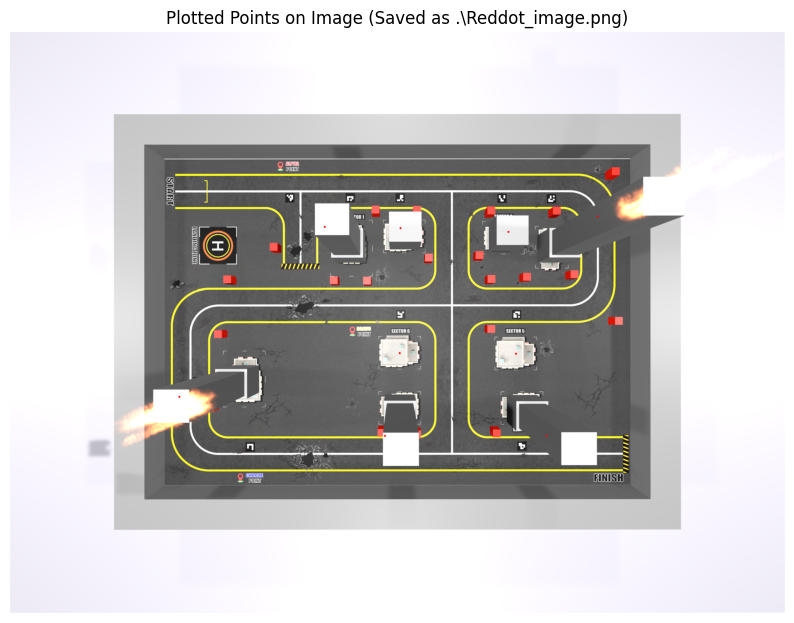

In [88]:

import numpy as np
import pandas as pd

# =======================================================
# 전역 설정 (나디르점과 비행 고도)
# =======================================================
ORIGINAL_NADIR_X = 2000.0
ORIGINAL_NADIR_Y = 1500.0
ALTITUDE_H = 2.5

# =======================================================
# 카메라 파라미터 (실제 사양 기반)
# =======================================================
SENSOR_SIZE_MM = 6.35      # 센서 크기 (mm)
FOV_DEGREES = 118          # 화각 (도)
IMAGE_WIDTH_PX = 4000      # 이미지 가로 픽셀 수 (예시)
IMAGE_HEIGHT_PX = 3000     # 이미지 세로 픽셀 수 (예시)

# 센서 대각선 및 초점거리 계산
SENSOR_DIAGONAL_MM = SENSOR_SIZE_MM * np.sqrt(2)
FOV_RADIANS = np.radians(FOV_DEGREES)
FOCAL_LENGTH_MM = SENSOR_DIAGONAL_MM / (2 * np.tan(FOV_RADIANS / 2))

# 렌즈 왜곡 계수 (Brown-Conrady 모델)
# 118도 광각 렌즈는 배럴 왜곡이 심함 - 실제 캘리브레이션 필요
# 여기서는 전형적인 광각 렌즈 왜곡 계수 예시값 사용
K1 = -0.3  # 방사 왜곡 계수 1 (음수 = 배럴 왜곡)
K2 = 0.1   # 방사 왜곡 계수 2
P1 = 0.0   # 접선 왜곡 계수 1
P2 = 0.0   # 접선 왜곡 계수 2

print("=" * 70)
print("카메라 설정")
print("=" * 70)
print(f"센서 크기: {SENSOR_SIZE_MM} mm")
print(f"화각: {FOV_DEGREES}°")
print(f"계산된 초점거리: {FOCAL_LENGTH_MM:.3f} mm")
print(f"이미지 해상도: {IMAGE_WIDTH_PX} x {IMAGE_HEIGHT_PX} px")
print(f"렌즈 왜곡 계수: K1={K1}, K2={K2}, P1={P1}, P2={P2}")
print("=" * 70)


def calculate_gsd(altitude, focal_length_mm, sensor_size_mm, image_size_px):
    """
    GSD (Ground Sample Distance) 계산
    
    Args:
        altitude: 비행 고도 (미터)
        focal_length_mm: 초점거리 (mm)
        sensor_size_mm: 센서 크기 (mm)
        image_size_px: 이미지 크기 (픽셀)
    
    Returns:
        gsd: 픽셀당 지상 거리 (미터/픽셀)
    """
    gsd = (sensor_size_mm / image_size_px) * (altitude / focal_length_mm)
    return gsd


def apply_lens_distortion_correction(x_px, y_px, cx, cy, image_width, image_height):
    """
    렌즈 왜곡 보정 (Brown-Conrady 모델)
    
    Args:
        x_px, y_px: 원본 픽셀 좌표
        cx, cy: 이미지 중심 (주점)
        image_width, image_height: 이미지 크기
    
    Returns:
        x_corrected, y_corrected: 보정된 픽셀 좌표
    """
    # 정규화된 좌표 (중심을 원점으로)
    x_norm = (x_px - cx) / (image_width / 2)
    y_norm = (y_px - cy) / (image_height / 2)
    
    # 반경
    r2 = x_norm**2 + y_norm**2
    r4 = r2**2
    
    # 방사 왜곡
    radial_distortion = 1 + K1 * r2 + K2 * r4
    
    # 접선 왜곡
    x_tangential = 2 * P1 * x_norm * y_norm + P2 * (r2 + 2 * x_norm**2)
    y_tangential = P1 * (r2 + 2 * y_norm**2) + 2 * P2 * x_norm * y_norm
    
    # 보정된 정규화 좌표
    x_norm_corrected = x_norm * radial_distortion + x_tangential
    y_norm_corrected = y_norm * radial_distortion + y_tangential
    
    # 픽셀 좌표로 변환
    x_corrected = cx + x_norm_corrected * (image_width / 2)
    y_corrected = cy + y_norm_corrected * (image_height / 2)
    
    return x_corrected, y_corrected


def calculate_rooftop_coords_advanced(df: pd.DataFrame, move_vector: np.ndarray = None, 
                                     apply_distortion_correction: bool = True) -> pd.DataFrame:
    """
    화각과 렌즈 왜곡을 고려한 옥상 좌표 계산
    
    Args:
        df: 건물 데이터 (index, x, y, height 컬럼 포함)
        move_vector: 촬영점 이동 벡터 [dx, dy]
        apply_distortion_correction: 렌즈 왜곡 보정 적용 여부
    
    Returns:
        계산된 결과 데이터프레임
    """
    
    if move_vector is None:
        move_vector = np.array([0.0, 0.0], dtype=np.float32)
    
    # 이동된 나디르점
    moved_nadir_x = ORIGINAL_NADIR_X + move_vector[0]
    moved_nadir_y = ORIGINAL_NADIR_Y + move_vector[1]
    
    print(f"\n원본 나디르점: ({ORIGINAL_NADIR_X}, {ORIGINAL_NADIR_Y})")
    print(f"이동된 나디르점: ({moved_nadir_x:.2f}, {moved_nadir_y:.2f})")
    
    # 바닥 좌표
    df['x_ground'] = df['x']
    df['y_ground'] = df['y']
    
    # 1. 렌즈 왜곡 보정
    if apply_distortion_correction and (K1 != 0 or K2 != 0):
        print("렌즈 왜곡 보정 적용 중...")
        corrected_coords = []
        for _, row in df.iterrows():
            x_corr, y_corr = apply_lens_distortion_correction(
                row['x_ground'], row['y_ground'],
                moved_nadir_x, moved_nadir_y,
                IMAGE_WIDTH_PX, IMAGE_HEIGHT_PX
            )
            corrected_coords.append([x_corr, y_corr])
        
        corrected_coords = np.array(corrected_coords)
        df['x_corrected'] = corrected_coords[:, 0]
        df['y_corrected'] = corrected_coords[:, 1]
    else:
        print("렌즈 왜곡 보정 미적용")
        df['x_corrected'] = df['x_ground']
        df['y_corrected'] = df['y_ground']
    
    # 2. GSD 계산
    gsd = calculate_gsd(ALTITUDE_H, FOCAL_LENGTH_MM, SENSOR_SIZE_MM, IMAGE_WIDTH_PX)
    print(f"GSD (Ground Sample Distance): {gsd:.6f} m/px")
    
    # 3. 픽셀 좌표를 실제 거리(미터)로 변환
    df['dx_px'] = df['x_corrected'] - moved_nadir_x
    df['dy_px'] = df['y_corrected'] - moved_nadir_y
    
    df['dx_m'] = df['dx_px'] * gsd
    df['dy_m'] = df['dy_px'] * gsd
    
    # 4. 나디르점으로부터의 거리 계산
    df['r_m'] = np.sqrt(df['dx_m']**2 + df['dy_m']**2)
    
    # 5. Relief Displacement 계산 (거리 기반)
    # d = r * (h / H)
    df['displacement_m'] = df['r_m'] * (df['height'] / ALTITUDE_H)
    
    # 6. 변위 방향 (단위 벡터)
    df['unit_x'] = np.where(df['r_m'] > 0, df['dx_m'] / df['r_m'], 0)
    df['unit_y'] = np.where(df['r_m'] > 0, df['dy_m'] / df['r_m'], 0)
    
    # 7. 변위량 (미터)
    df['disp_x_m'] = df['displacement_m'] * df['unit_x']
    df['disp_y_m'] = df['displacement_m'] * df['unit_y']
    
    # 8. 옥상 좌표 (미터 단위에서 계산 후 픽셀로 역변환)
    df['rooftop_x'] = df['x_corrected'] + (df['disp_x_m'] / gsd)
    df['rooftop_y'] = df['y_corrected'] + (df['disp_y_m'] / gsd)
    
    # 결과 정리
    output_df = df[['index', 'x', 'y', 'height', 'x_corrected', 'y_corrected', 
                    'r_m', 'displacement_m', 'rooftop_x', 'rooftop_y']].copy()
    output_df['moved_nadir_x'] = moved_nadir_x
    output_df['moved_nadir_y'] = moved_nadir_y
    output_df['gsd'] = gsd
    
    return output_df


# =======================================================
# 실행부
# =======================================================

# 1. 건물 데이터 준비
data = {
    'index': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'x': [1763.5, 2035.0, 2548.0, 2798.0, 2611.0, 2011.5, 1208.0, 2010.0, 2641.0],
    'y': [1120.0, 1059.0, 1069.5, 1117.5, 1663.0, 1660.0, 1791.5, 1943.0, 1945.0],
    'height': [0.728, 0.241, 0.198, 1.050, 0.000, 0.000, 0.809, 0.810, 0.792]
}
df = pd.DataFrame(data)

# 2. 촬영점 이동 벡터
move_vector = np.array([240.0, -0.25], dtype=np.float32)

# 3. 옥상 좌표 계산 (왜곡 보정 적용)
print("\n" + "=" * 70)
print("왜곡 보정 적용 버전")
print("=" * 70)
result_with_correction = calculate_rooftop_coords_advanced(df.copy(), move_vector, 
                                                           apply_distortion_correction=True)

print("\n--- 최종 옥상 좌표 계산 결과 (왜곡 보정 적용) ---")
print(result_with_correction[['index', 'x', 'y', 'height', 'rooftop_x', 'rooftop_y']].to_string(index=False))

# 4. 비교: 왜곡 보정 미적용
print("\n" + "=" * 70)
print("왜곡 보정 미적용 버전 (비교용)")
print("=" * 70)
result_without_correction = calculate_rooftop_coords_advanced(df.copy(), move_vector, 
                                                              apply_distortion_correction=False)

print("\n--- 최종 옥상 좌표 계산 결과 (왜곡 보정 미적용) ---")
print(result_without_correction[['index', 'x', 'y', 'height', 'rooftop_x', 'rooftop_y']].to_string(index=False))

# 5. 차이 비교
print("\n" + "=" * 70)
print("왜곡 보정 적용 전후 차이")
print("=" * 70)
diff_df = pd.DataFrame({
    'index': result_with_correction['index'],
    'x': result_with_correction['x'],
    'y': result_with_correction['y'],
    'height': result_with_correction['height'],
    'diff_x': result_with_correction['rooftop_x'] - result_without_correction['rooftop_x'],
    'diff_y': result_with_correction['rooftop_y'] - result_without_correction['rooftop_y'],
    'diff_magnitude': np.sqrt(
        (result_with_correction['rooftop_x'] - result_without_correction['rooftop_x'])**2 +
        (result_with_correction['rooftop_y'] - result_without_correction['rooftop_y'])**2
    )
})

print(diff_df.to_string(index=False))

print(f"\n평균 차이: {diff_df['diff_magnitude'].mean():.4f} 픽셀")
print(f"최대 차이: {diff_df['diff_magnitude'].max():.4f} 픽셀")



카메라 설정
센서 크기: 6.35 mm
화각: 118°
계산된 초점거리: 2.698 mm
이미지 해상도: 4000 x 3000 px
렌즈 왜곡 계수: K1=-0.3, K2=0.1, P1=0.0, P2=0.0

왜곡 보정 적용 버전

원본 나디르점: (2000.0, 1500.0)
이동된 나디르점: (2240.00, 1499.75)
렌즈 왜곡 보정 적용 중...
GSD (Ground Sample Distance): 0.001471 m/px

--- 최종 옥상 좌표 계산 결과 (왜곡 보정 적용) ---
 index      x      y  height   rooftop_x   rooftop_y
     1 1763.5 1120.0   0.728 1646.151860 1026.478581
     2 2035.0 1059.0   0.241 2021.557274 1030.098139
     3 2548.0 1069.5   0.198 2562.197947 1049.666667
     4 2798.0 1117.5   1.050 3000.035146  979.098684
     5 2611.0 1663.0   0.000 2605.931201 1660.769592
     6 2011.5 1660.0   0.000 2013.163495 1658.833369
     7 1208.0 1791.5   0.809  986.024483 1854.253253
     8 2010.0 1943.0   0.810 1944.357562 2069.504394
     9 2641.0 1945.0   0.792 2748.580370 2064.451770

왜곡 보정 미적용 버전 (비교용)

원본 나디르점: (2000.0, 1500.0)
이동된 나디르점: (2240.00, 1499.75)
렌즈 왜곡 보정 미적용
GSD (Ground Sample Distance): 0.001471 m/px

--- 최종 옥상 좌표 계산 결과 (왜곡 보정 미적용) ---
 index      x      y

시각화 결과가 성공적으로 저장되었습니다: .\Reddot_image.png


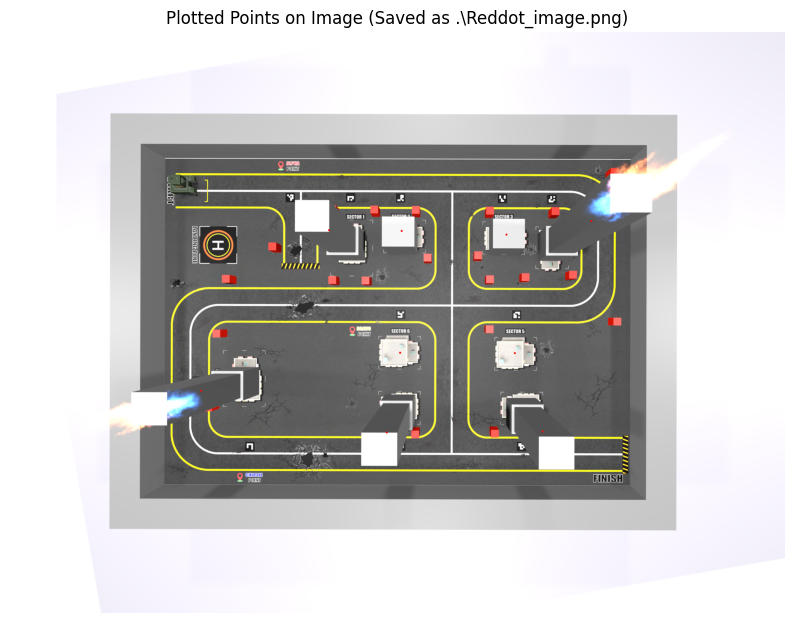

In [89]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def plot_points_on_image_cv2(df: pd.DataFrame, input_image_path: str, output_image_path: str):
    """
    OpenCV(cv2)를 사용하여 입력 이미지 위에 'rooftop_x'와 'rooftop_y' 좌표의 점을 찍고
    결과 이미지를 저장하는 함수입니다.
    
    Args:
        df (pd.DataFrame): 'rooftop_x'와 'rooftop_y' 좌표를 포함하는 데이터프레임.
        input_image_path (str): 배경 이미지 파일 경로.
        output_image_path (str): 결과를 저장할 이미지 파일 경로.
    """
    
    # 1. 이미지 로드
    img = cv2.imread(input_image_path)
    
    if img is None:
        print(f"오류: 이미지를 로드할 수 없습니다. 경로를 확인하세요: {input_image_path}")
        return

    # 2. 좌표 컬럼 확인
    x_col = 'rooftop_x'
    y_col = 'rooftop_y'
    
    if x_col not in df.columns or y_col not in df.columns:
        print(f"오류: 데이터프레임에 필수 컬럼 ('{x_col}', '{y_col}')이 없습니다.")
        return

    # 3. 점 찍기
    # OpenCV는 BGR 순서로 색상을 사용합니다. (0, 0, 255)는 빨간색입니다.
    point_color = (0, 0, 255) # Red
    point_radius = 5
    point_thickness = -1 # -1은 채우기

    for index, row in df.iterrows():
        # 좌표를 정수로 변환
        x = int(row[x_col])
        y = int(row[y_col])
        
        # 이미지 경계 확인
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (x, y), point_radius, point_color, point_thickness)
        else:
            print(f"경고: 좌표 ({x}, {y})가 이미지 경계를 벗어났습니다. 해당 점은 무시됩니다.")

    # 4. 결과 저장
    cv2.imwrite(output_image_path, img)
    print(f"시각화 결과가 성공적으로 저장되었습니다: {output_image_path}")

    # 5. 시각화 (Jupyter 환경에서 OpenCV 이미지를 표시하기 위해 Matplotlib 사용)
    # OpenCV는 BGR을 사용하므로, Matplotlib으로 표시하기 위해 RGB로 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(f"Plotted Points on Image (Saved as {output_image_path})")
    plt.axis('off') # 축 정보 제거
    plt.show()

image_e=r'.\Reddot_image.png'
plot_points_on_image_cv2(result_with_correction,image_d, image_e)